In [21]:
import pandas as pd


In [22]:
full_data = pd.read_csv("weatherAUS.csv")

In [23]:
full_data['RainToday'].replace({'No': 0, 'Yes': 1},inplace = True)
full_data['RainTomorrow'].replace({'No': 0, 'Yes': 1},inplace = True)

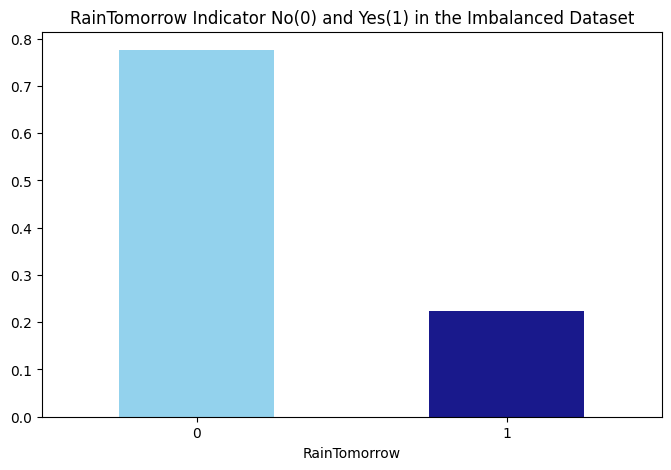

In [24]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (8,5))
full_data.RainTomorrow.value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) in the Imbalanced Dataset')
plt.show()

In [25]:
# If you haven't installed scikit-learn yet, uncomment the following line:
# !pip install scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

# Assuming full_data is already defined
no = full_data[full_data.RainTomorrow == 0]
yes = full_data[full_data.RainTomorrow == 1]

# Oversample the minority class
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)

# Combine the oversampled minority class with the majority class
oversampled = pd.concat([no, yes_oversampled])

# Plot the balanced dataset
fig = plt.figure(figsize=(8, 5))
oversampled.RainTomorrow.value_counts(normalize=True).plot(kind='bar', color=['skyblue', 'navy'], alpha=0.9, rot=0)
plt.title('RainTomorrow Indicator No(0) and Yes(1) after Oversampling (Balanced Dataset)')
plt.show()


ModuleNotFoundError: No module named 'sklearn'

<Axes: >

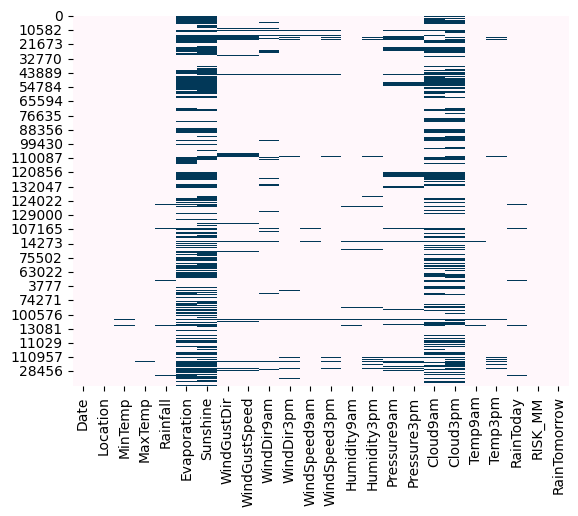

In [ ]:
# Missing Data Pattern in Training Data
import seaborn as sns
sns.heatmap(oversampled.isnull(), cbar=False, cmap='PuBu')

In [ ]:
total = oversampled.isnull().sum().sort_values(ascending=False)
percent = (oversampled.isnull().sum()/oversampled.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head(4)

,Total,Percent
Sunshine,104831,0.475140
Evaporation,95411,0.432444
Cloud3pm,85614,0.388040
Cloud9am,81339,0.368664


In [ ]:
oversampled.select_dtypes(include=['object']).columns


Index(['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], dtype='object')

In [ ]:
# Impute categorical var with Mode
oversampled['Date'] = oversampled['Date'].fillna(oversampled['Date'].mode()[0])
oversampled['Location'] = oversampled['Location'].fillna(oversampled['Location'].mode()[0])
oversampled['WindGustDir'] = oversampled['WindGustDir'].fillna(oversampled['WindGustDir'].mode()[0])
oversampled['WindDir9am'] = oversampled['WindDir9am'].fillna(oversampled['WindDir9am'].mode()[0])
oversampled['WindDir3pm'] = oversampled['WindDir3pm'].fillna(oversampled['WindDir3pm'].mode()[0])


In [ ]:
# Convert categorical features to continuous features with Label Encoding
from sklearn.preprocessing import LabelEncoder
lencoders = {}
for col in oversampled.select_dtypes(include=['object']).columns:
    lencoders[col] = LabelEncoder()
    oversampled[col] = lencoders[col].fit_transform(oversampled[col])


In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

# Use a simpler estimator and reduce the number of iterations
mice_imputer = IterativeImputer(estimator=LinearRegression(), max_iter=5, random_state=0)

# Perform imputation
MiceImputed = oversampled.copy(deep=True)
MiceImputed.iloc[:, :] = mice_imputer.fit_transform(oversampled)

In [ ]:
# Detecting outliers with IQR
Q1 = MiceImputed.quantile(0.25)
Q3 = MiceImputed.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Date             1535.000000
Location           25.000000
MinTemp             9.300000
MaxTemp            10.200000
Rainfall            2.400000
Evaporation         4.118151
Sunshine            5.877605
WindGustDir         9.000000
WindGustSpeed      19.000000
WindDir9am          8.000000
WindDir3pm          8.000000
WindSpeed9am       13.000000
WindSpeed3pm       11.000000
Humidity9am        26.000000
Humidity3pm        30.000000
Pressure9am         8.600000
Pressure3pm         8.600000
Cloud9am            4.000000
Cloud3pm            3.628532
Temp9am             9.300000
Temp3pm             9.800000
RainToday           1.000000
RISK_MM             5.200000
RainTomorrow        1.000000
dtype: float64


In [ ]:
# Removing outliers from the dataset
MiceImputed = MiceImputed[~((MiceImputed < (Q1 - 1.5 * IQR)) |(MiceImputed > (Q3 + 1.5 * IQR))).any(axis=1)]
MiceImputed.shape

(156473, 24)

<Axes: >

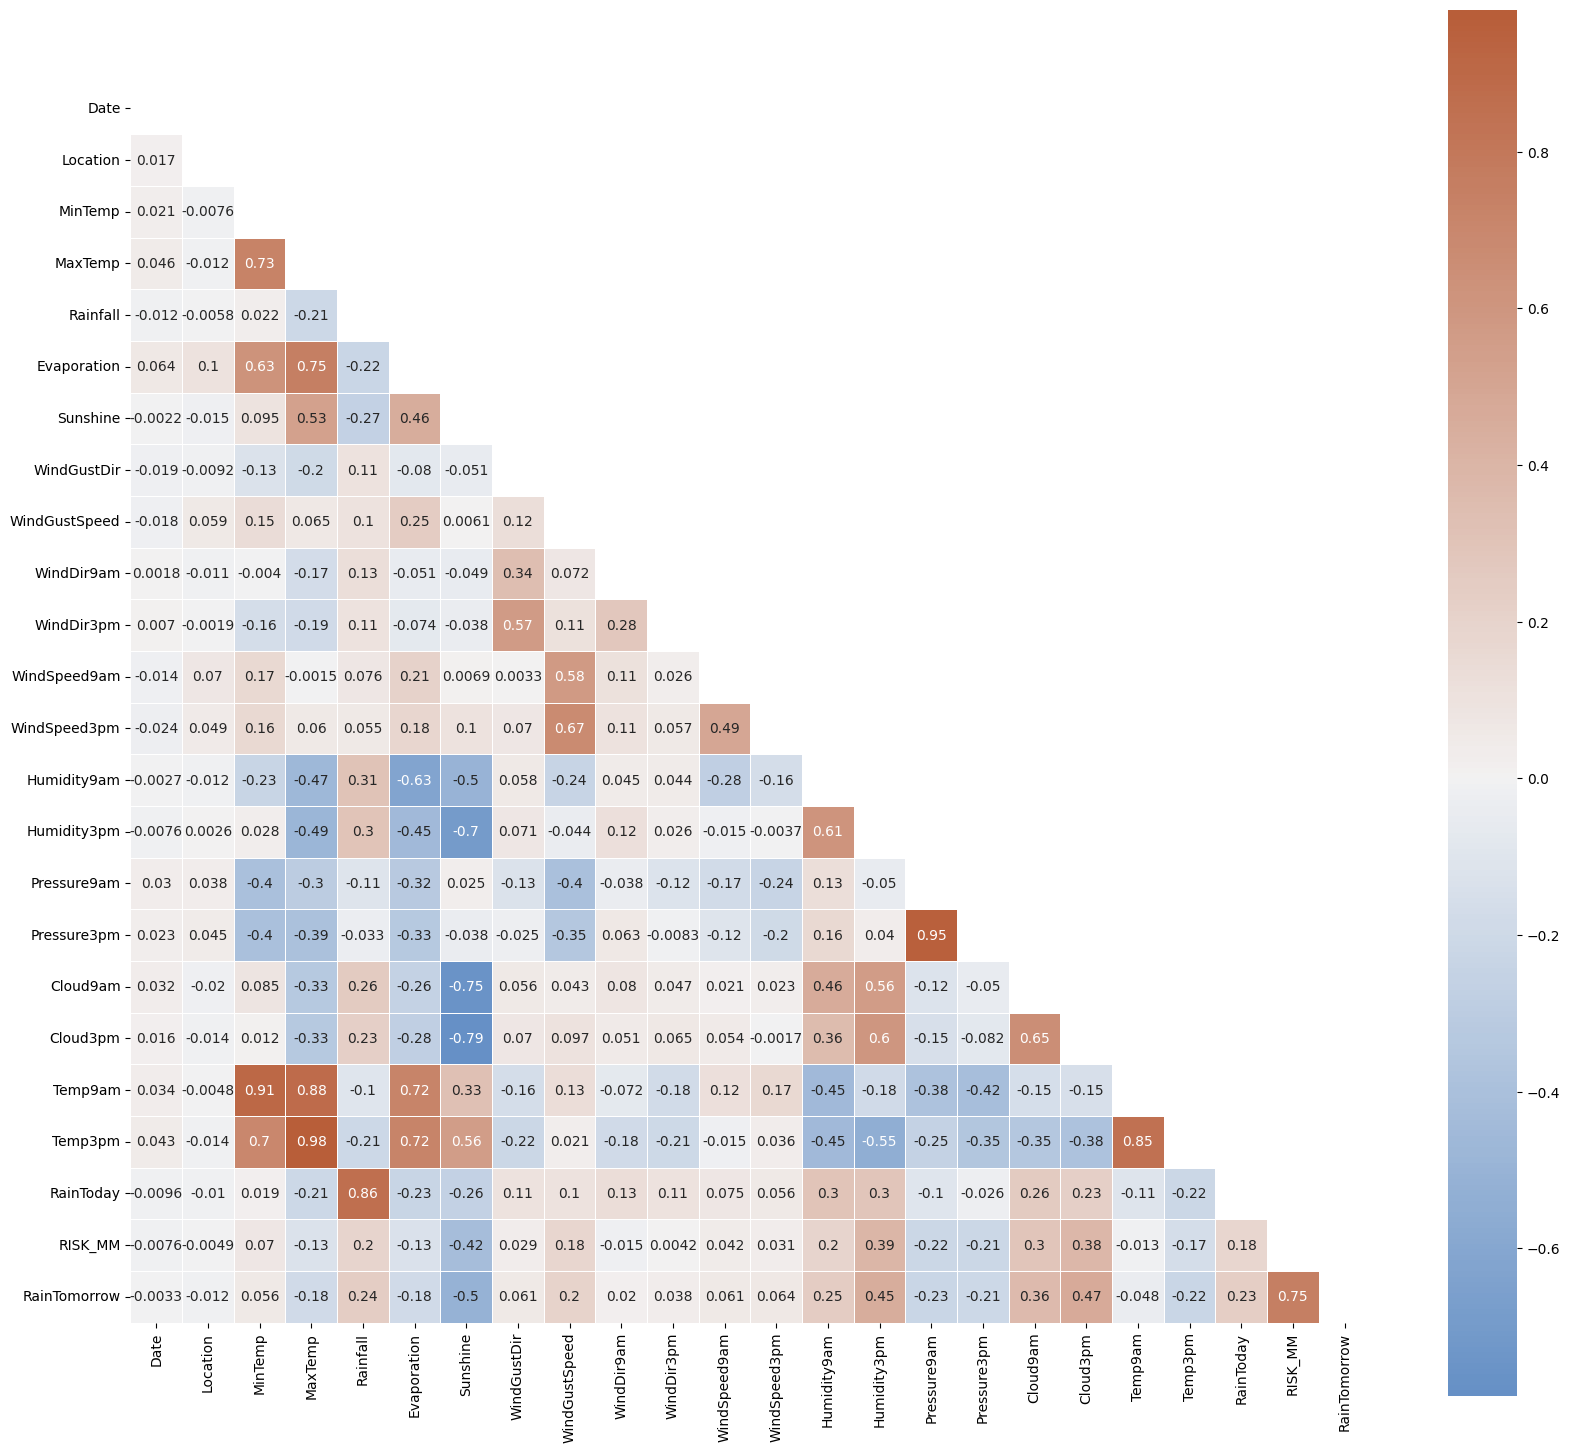

In [ ]:
# Correlation Heatmap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
corr = MiceImputed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=None, center=0,square=True, annot=True, linewidths=.5, cbar_kws={"shrink": .9})

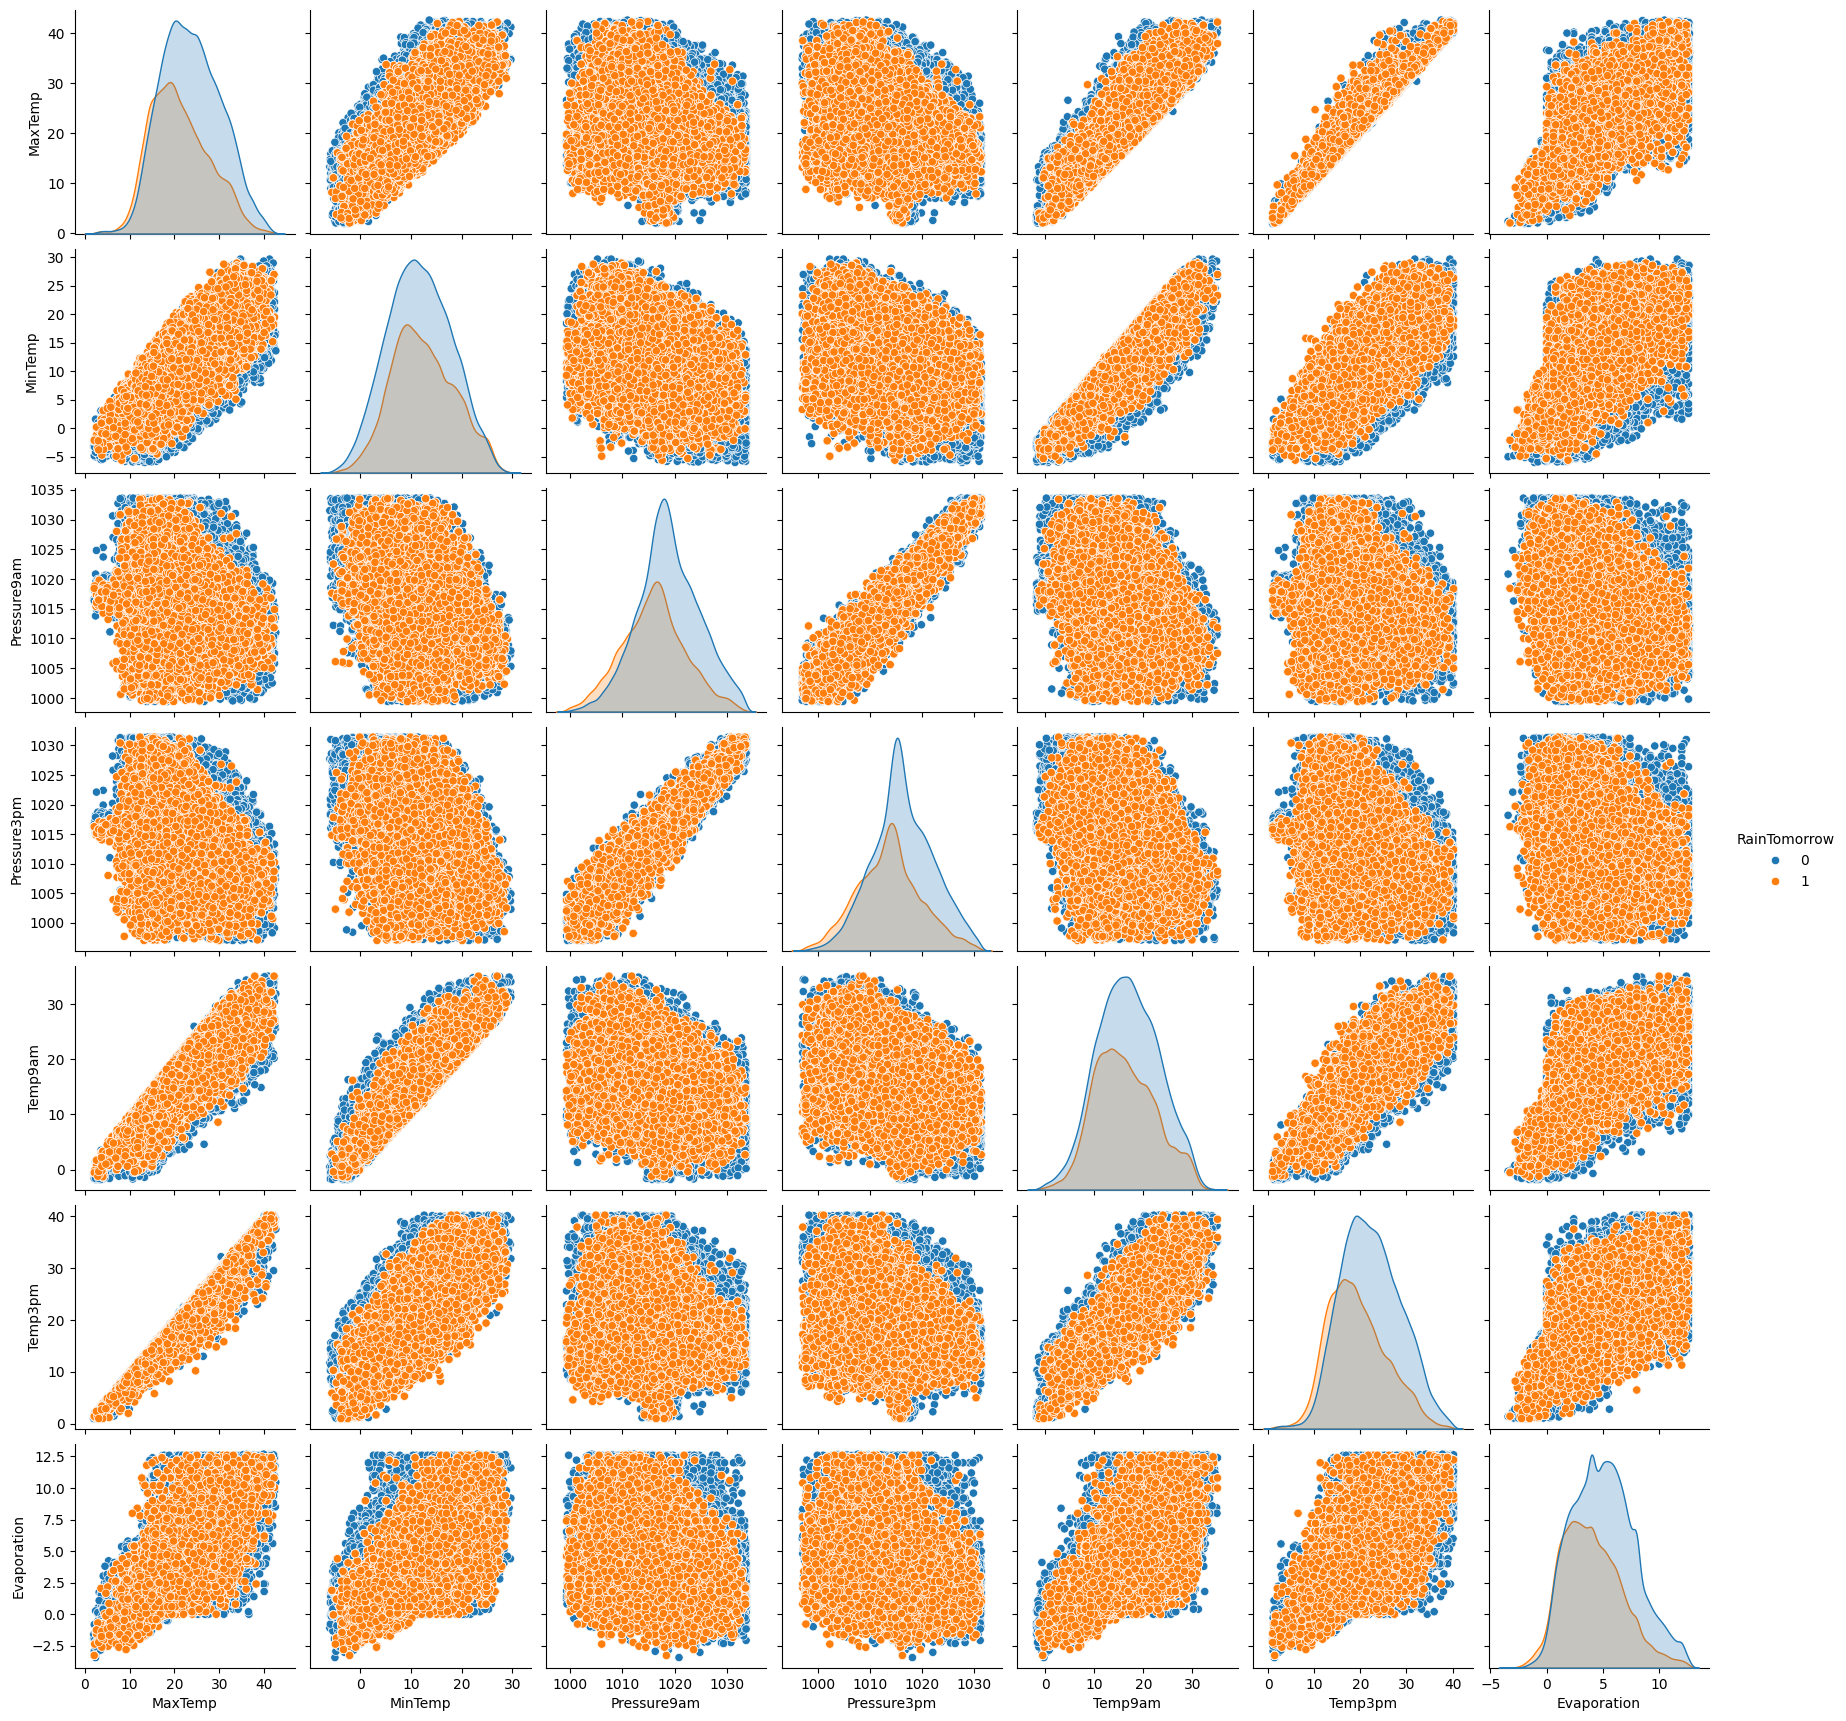

In [ ]:
sns.pairplot( data=MiceImputed, vars=('MaxTemp','MinTemp','Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm', 'Evaporation'), hue='RainTomorrow' )

In [ ]:
# Standardizing data
from sklearn import preprocessing
r_scaler = preprocessing.MinMaxScaler()
r_scaler.fit(MiceImputed)
modified_data = pd.DataFrame(r_scaler.transform(MiceImputed), index=MiceImputed.index, columns=MiceImputed.columns)


In [ ]:
# Feature Importance using Filter Method (Chi-Square)
from sklearn.feature_selection import SelectKBest, chi2
X = modified_data.loc[:,modified_data.columns!='RainTomorrow']
y = modified_data[['RainTomorrow']]
selector = SelectKBest(chi2, k=10)
selector.fit(X, y)
X_new = selector.transform(X)
print(X.columns[selector.get_support(indices=True)])

Index(['Sunshine', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
       'Cloud9am', 'Cloud3pm', 'Temp3pm', 'RainToday', 'RISK_MM'],
      dtype='object')


In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier as rf

X = MiceImputed.drop('RainTomorrow', axis=1)
y = MiceImputed['RainTomorrow']
selector = SelectFromModel(rf(n_estimators=100, random_state=0))
selector.fit(X, y)
support = selector.get_support()
features = X.loc[:,support].columns.tolist()
print(features)
print(rf(n_estimators=100, random_state=0).fit(X,y).feature_importances_)

['Sunshine', 'Cloud3pm', 'RISK_MM']
[0.00233608 0.00257386 0.00291934 0.00401399 0.01072205 0.00267512
 0.06196831 0.00163828 0.00794172 0.0019329  0.00193109 0.00155852
 0.00216162 0.00731007 0.03460588 0.00817436 0.01313512 0.01957172
 0.05306162 0.00311747 0.0057028  0.00398492 0.74696315]


In [ ]:
features = MiceImputed[['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 
                       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
                       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 
                       'RainToday']]
target = MiceImputed['RainTomorrow']

# Split into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=12345)

# Normalize Features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [ ]:
def plot_roc_cur(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()